# Mapping outcomes

## Proportions of stroke types: Analysis of SAMueL data

## Import packages

In [3]:
# import contextily as ctx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo  # to make catchment area geometry

pd.set_option('display.max_rows', 150)

In [4]:
dir_output = 'output'
limit_to_england = False

## Load data

### Load shape file

In [5]:
lsoa_gdf = stroke_maps.load_data.lsoa_geography()
lsoa_gdf = lsoa_gdf.to_crs('EPSG:27700')

lsoa_gdf.head(3)

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.09706,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((532282.642 181906.500, 532248.262 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.09197,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((532746.826 181786.896, 532248.262 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.09523,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((532293.080 182068.426, 532419.605 18..."


In [6]:
# Load country outline
# outline = geopandas.read_file('./data/Countries_(December_2022)_GB_BFC.zip')
if limit_to_england:
    # mask = outline['CTRY22NM'] == 'England'
    # outline = outline[mask]
    outline = stroke_maps.load_data.england_outline()
else:
    # mask = (outline['CTRY22NM'] == 'England') | (outline['CTRY22NM'] == 'Wales')
    # outline = outline[mask]
    outline = stroke_maps.load_data.englandwales_outline()

In [7]:
outline

,country,OBJECTID,ctry11cd,ctry11cdo,ctry11nm,ctry11nmw,GlobalID,geometry
0,0,1,E92000001,921,England,Lloegr,27bbf7ca-99bd-4fe8-87a1-d498d48e3084,"MULTIPOLYGON (((83994.599 5397.099, 84001.300 ..."


### Load hospital info

Load in the stroke unit coordinates and merge in the services information:

In [8]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

df_units.head(3).T

postcode,SY231ER,CB20QQ,L97AL
stroke_team,Bronglais Hospital (Aberystwyth),"Addenbrooke's Hospital, Cambridge","University Hospital Aintree, Liverpool"
short_code,AB,AD,AI
ssnap_name,Bronglais Hospital,Addenbrooke's Hospital,University Hospital Aintree
use_ivt,1,1,1
use_mt,0,1,1
use_msu,0,1,1
transfer_unit_postcode,nearest,nearest,nearest
lsoa,Ceredigion 002A,Cambridge 013D,Liverpool 005A
lsoa_code,W01000512,E01017995,E01006654
region,Hywel Dda University Health Board,NHS Cambridgeshire and Peterborough ICB - 06H,NHS Cheshire and Merseyside ICB - 99A


In [9]:
hospitals_gdf = stroke_maps.load_data.stroke_unit_coordinates()
hospitals_gdf = pd.merge(
    hospitals_gdf, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

In [10]:
hospitals_gdf.head(3)

,BNG_E,BNG_N,Latitude,Longitude,geometry,use_ivt,use_mt
postcode,,,,,,,
SY231ER,259208,281805,52.416068,-4.071578,POINT (259208.000 281805.000),1,0
CB20QQ,546375,254988,52.173741,0.139114,POINT (546375.000 254988.000),1,1
L97AL,338020,397205,53.467918,-2.935131,POINT (338020.000 397205.000),1,1


### Load LSOA model output data

In [11]:
lsoa_data = pd.read_csv(os.path.join(dir_output, 'cohort_outcomes_weighted.csv'))
lsoa_data.head(3).T

,0,1,2
lsoa,Adur 001A,Adur 001B,Adur 001C
closest_ivt_time,17.6,18.7,17.6
closest_ivt_unit,BN25BE,BN25BE,BN112DH
closest_mt_time,17.6,18.7,19.8
closest_mt_unit,BN25BE,BN25BE,BN25BE
transfer_mt_time,0.0,0.0,31.6
transfer_mt_unit,BN25BE,BN25BE,BN25BE
mt_transfer_required,False,False,True
ivt_drip_ship,107.6,108.7,107.6
mt_drip_ship,167.6,168.7,259.2


In [12]:
# Merge with shape file

lsoa_data_gdf = lsoa_gdf.merge(lsoa_data, left_on='LSOA11NM', right_on='lsoa', how='right')
lsoa_data_gdf.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,...,mothership_weighted_mrs_shift,mothership_weighted_added_mrs_less_equal_2,drip_ship_weighted_treated_added_utility,drip_ship_weighted_treated_mrs_less_equal_2,drip_ship_weighted_treated_mrs_shift,drip_ship_weighted_treated_added_mrs_less_equal_2,mothership_weighted_treated_added_utility,mothership_weighted_treated_mrs_less_equal_2,mothership_weighted_treated_mrs_shift,mothership_weighted_treated_added_mrs_less_equal_2
0,30557.0,E01031349,Adur 001A,Adur 001A,524915.0,105607.0,-0.22737,50.83651,3.641032e+05,3054.751704,...,-0.178152,0.036258,0.136330,0.566888,-0.715921,0.145707,0.136330,0.566888,-0.715921,0.145707
1,30558.0,E01031350,Adur 001B,Adur 001B,524825.0,106265.0,-0.22842,50.84244,2.921732e+05,2977.102897,...,-0.177400,0.036112,0.135791,0.566301,-0.712902,0.145120,0.135791,0.566301,-0.712902,0.145120
2,30559.0,E01031351,Adur 001C,Adur 001C,523053.0,108004.0,-0.25300,50.85845,5.281768e+06,11671.349143,...,-0.176649,0.035966,0.111059,0.539792,-0.580860,0.118610,0.135251,0.565714,-0.709882,0.144533
3,30560.0,E01031352,Adur 001D,Adur 001D,524141.0,106299.0,-0.23812,50.84290,2.452292e+05,2134.908586,...,-0.176649,0.035966,0.111059,0.539792,-0.580860,0.118610,0.135251,0.565714,-0.709882,0.144533
4,30578.0,E01031370,Adur 001E,Adur 001E,523561.0,105916.0,-0.24649,50.83958,2.402445e+05,2447.096939,...,-0.176649,0.035966,0.111591,0.540364,-0.583788,0.119183,0.135251,0.565714,-0.709882,0.144533


In [13]:
cols = [c for c in lsoa_data_gdf.columns if (('lvo' in c) & ('nlvo' not in c) & ('utility' in c))]

lsoa_data_gdf[cols].head(10).T

,0,1,2,3,4,5,6,7,8,9
drip_ship_lvo_ivt_added_utility,0.058718,0.058412,0.058718,0.058718,0.059024,0.058718,0.058718,0.058718,0.058718,0.058718
drip_ship_lvo_ivt_mt_added_utility,0.163611,0.162952,0.109278,0.109278,0.109921,0.109278,0.109278,0.109278,0.109278,0.109278
drip_ship_lvo_mt_added_utility,0.163611,0.162952,0.109278,0.109278,0.109921,0.109278,0.109278,0.109278,0.109278,0.109278
mothership_lvo_ivt_added_utility,0.058718,0.058412,0.058107,0.058107,0.058107,0.058412,0.057829,0.057524,0.057524,0.057524
mothership_lvo_ivt_mt_added_utility,0.163611,0.162952,0.162292,0.162292,0.162292,0.162952,0.161693,0.161033,0.161033,0.161033
mothership_lvo_mt_added_utility,0.163611,0.162952,0.162292,0.162292,0.162292,0.162952,0.161693,0.161033,0.161033,0.161033
drip_ship_lvo_mix_added_utility,0.155483,0.154851,0.105360,0.105360,0.105977,0.105360,0.105360,0.105360,0.105360,0.105360
mothership_lvo_mix_added_utility,0.155483,0.154851,0.154219,0.154219,0.154219,0.154851,0.153644,0.153012,0.153012,0.153012


## Calculate difference between Mothership and Drip and Ship

In [18]:
cohort_names = ['nlvo_ivt', 'lvo_mix', 'weighted_treated']

outcome_names = ['added_utility', 'added_mrs_less_equal_2', 'mrs_shift']

In [19]:
cols_diff = [f'{c}_{o}_mothership_minus_dripship' for c in cohort_names for o in outcome_names]
cols_moth = [f'mothership_{c}_{o}' for c in cohort_names for o in outcome_names]
cols_drip = [f'drip_ship_{c}_{o}' for c in cohort_names for o in outcome_names]

lsoa_data_gdf[cols_diff] = lsoa_data_gdf[cols_moth].values - lsoa_data_gdf[cols_drip].values

## Plots

In [20]:
col_titles = ['nLVO', 'LVO', 'Treated ischaemic population']
row_titles = ['Drip and ship', 'Mothership', 'Advantage of\n mothership']

In [21]:
from matplotlib.gridspec import GridSpec

In [49]:
def plot_nine(
        data_field,
        data_name,
        lsoa_data_gdf,
        hospitals_gdf,
        outline,
        reverse_cmaps=False,
        col_titles=[],
        row_titles=[],
    ):
    fig = plt.figure(figsize=(14, 18))

    # Set up GridSpec so that each map subplot takes up two gs subplots
    # in height. This lets the shared colourbar sit midway up two
    # subplots instead of being offset or twice the height of the other.
    gs = GridSpec(7, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.0, hspace=0.0)
    axs = np.array([
        [plt.subplot(gs[0:2, 0]), plt.subplot(gs[0:2, 1]), plt.subplot(gs[0:2, 2])],
        [plt.subplot(gs[2:4, 0]), plt.subplot(gs[2:4, 1]), plt.subplot(gs[2:4, 2])],
        [plt.subplot(gs[4:6, 0]), plt.subplot(gs[4:6, 1]), plt.subplot(gs[4:6, 2])],
    ])
    cax = plt.subplot(gs[1:3, -1])
    cax_diff = plt.subplot(gs[4:6, -1])
    
    ################### Plot data values ###################
    
    cols = [
        f'drip_ship_nlvo_ivt_{data_field}',
        f'mothership_nlvo_ivt_{data_field}',
        f'drip_ship_lvo_mix_{data_field}',
        f'mothership_lvo_mix_{data_field}',
        f'drip_ship_weighted_treated_{data_field}',
        f'mothership_weighted_treated_{data_field}',
    ]

    cmap = 'inferno'
    cmap_diff = 'bwr_r'
    if reverse_cmaps:
        cmap += '_r'
        cmap_diff += '_r'
        # Remove the double reverse reverse:
        cmap = cmap.split('_r_r')[0]
        cmap_diff = cmap_diff.split('_r_r')[0]

    # Find maximum of data
    vmin = np.min([lsoa_data_gdf[col].min() for col in cols])
    vmax = np.max([lsoa_data_gdf[col].max() for col in cols])
    
    for i, col in enumerate(cols):
        ax = axs[i % 2, i // 2]
    
        # Plot data
        lsoa_data_gdf.plot(
            ax=ax, # Set which axes to use for plot (only one here)
            column=col, # Column to apply colour
            antialiased=False, # Avoids artifact boundry lines
            edgecolor='face', # Make LSOA boundry same colour as area
            vmin=vmin, # Manual scale min (remove to make automatic)
            vmax=vmax, # Manual scale max (remove to make automatic)
            cmap=cmap, # Colour map to use
            # Adjust size of colourmap key, and add label
            legend_kwds={'shrink':0.5, 'label':f'{data_name}'},
            # Set to display legend
            legend=True,
            cax=cax
        )
        
        # Add country boarder
        outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
        
        # Add hospitals
        mask = hospitals_gdf['use_ivt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
        mask = hospitals_gdf['use_mt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')
    
        # Tighten map around mainland England and Wales
        ax.set_xlim(120000)

        # ax.set_axis_off() # Turn of axis line and numbers
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_visible(False)
    
    ################### Plot differences between mothership and drip and ship ###################
    
    cols = [
        f'nlvo_ivt_{data_field}_mothership_minus_dripship',
        f'lvo_mix_{data_field}_mothership_minus_dripship',
        f'weighted_treated_{data_field}_mothership_minus_dripship',
    ]
    
    # Find absolute maximum of data extent
    vmax = np.max((np.abs([lsoa_data_gdf[col].min() for col in cols]), 
                   np.abs([lsoa_data_gdf[col].max() for col in cols])))
    vmin = -vmax
        
    for i, col in enumerate(cols):
        ax = axs[2, i]
    
        lsoa_data_gdf.plot(
            ax=ax, # Set which axes to use for plot (only one here)
            column=col, # Column to apply colour
            antialiased=False, # Avoids artifact boundry lines
            edgecolor='face', # Make LSOA boundry same colour as area
            vmin=vmin, # Manual scale min (remove to make automatic)
            vmax=vmax, # Manual scale max (remove to make automatic)
            cmap=cmap_diff, # Colour map to use
            # Adjust size of colourmap key, and add label
            legend_kwds={'shrink':0.5, 'label':f'Advantage of Mothership ({data_name})'},
            # Set to display legend
            legend=True,
            cax=cax_diff
        )
    
        # Add country boarder
        outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
        
        # Add hospitals
        mask = hospitals_gdf['use_ivt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
        mask = hospitals_gdf['use_mt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

        # ax.set_axis_off() # Turn of axis line and numbers
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_visible(False)
    
        # Tighten map around mainland England and Wales
        ax.set_xlim(120000)

    for i, row_title in enumerate(row_titles):
        axs[i, 0].set_ylabel(row_title, rotation=0, fontsize=14, labelpad=50.0)#, ha='right')
    for i, col_title in enumerate(col_titles):
        axs[0, i].set_xlabel(col_title, fontsize=14)
        axs[0, i].xaxis.set_label_position('top')
    
    plt.tight_layout(pad=1)
    plt.savefig(f'./output/{data_field}_nine_in_one.jpg', dpi=300, bbox_inches='tight')
    plt.show()

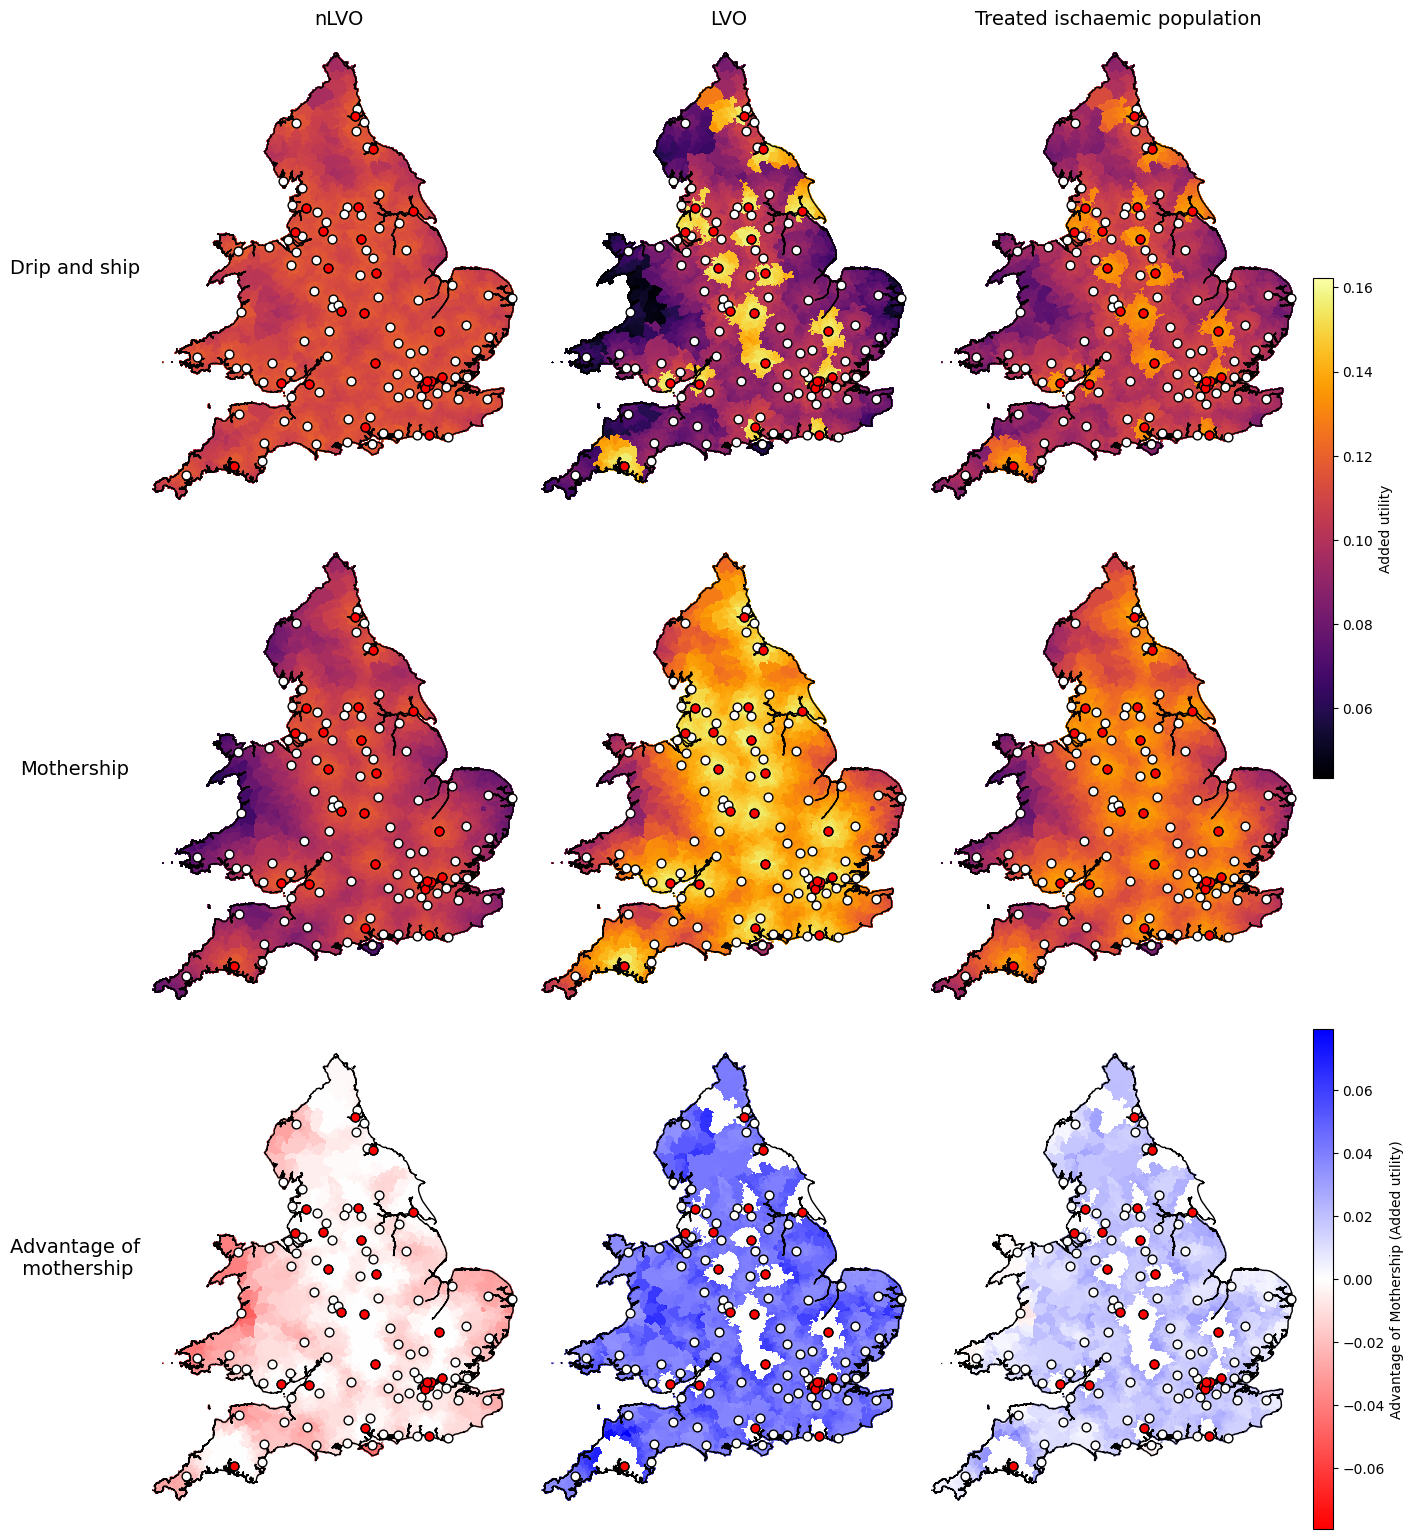

In [50]:
plot_nine(
    'added_utility',
    'Added utility',  # for labels
    lsoa_data_gdf,
    hospitals_gdf,
    outline,
    row_titles=row_titles,
    col_titles=col_titles,
)

In [ ]:
def plot_six(
        data_field,
        data_name,
        lsoa_data_gdf,
        hospitals_gdf,
        outline,
        reverse_cmaps=False
    ):
    fig = plt.figure(figsize=(18,12))
    
    ################### Plot data values ###################
    
    cols = [
        f'drip_ship_nlvo_ivt_{data_field}',
        f'mothership_nlvo_ivt_{data_field}',
        f'drip_ship_lvo_mix_{data_field}',
        f'mothership_lvo_mix_{data_field}'
    ]
    
    titles = [
        f'Drip and ship nLVO {data_name}',
        f'Mothership nLVO {data_name}',
        f'Drip and ship LVO {data_name}',    
        f'Mothership LVO {data_name}'
    ]

    cmap = 'inferno'
    cmap_diff = 'bwr_r'
    if reverse_cmaps:
        cmap += '_r'
        cmap_diff += '_r'
        cmap = cmap.split('_r_r')[0]
        cmap_diff = cmap_diff.split('_r_r')[0]
    
    # Indexes for subplots (to leave gaps on right for diff between Mothership and Drip and Ship)
    indexes = [1, 2, 4, 5]
    
    # Find maximum of data
    vmin = np.min([lsoa_data_gdf[col].min() for col in cols])
    vmax = np.max([lsoa_data_gdf[col].max() for col in cols])
    
    for i in range(4):
        ax = fig.add_subplot(2, 3, indexes[i])
    
        # Plot data
        lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                     column=cols[i], # Column to apply colour
                     antialiased=False, # Avoids artifact boundry lines
                     edgecolor='face', # Make LSOA boundry same colour as area
                     vmin=vmin, # Manual scale min (remove to make automatic)
                     vmax=vmax, # Manual scale max (remove to make automatic)
                     cmap=cmap, # Colour map to use
                     # Adjust size of colourmap key, and add label
                     legend_kwds={'shrink':0.5, 'label':f'{data_name}'},
                     # Set to display legend
                     legend=True)
        
        # Add country boarder
        outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
        
        # Add hospitals
        mask = hospitals_gdf['use_ivt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
        mask = hospitals_gdf['use_mt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')
    
        # Tighten map around mainland England and Wales
        ax.set_xlim(120000)
    
        ax.set_title(titles[i])
        ax.set_axis_off() # Turn of axis line and numbers
    
    ################### Plot differences between mothership and drip and ship ###################
    
    cols = [
        f'nlvo_ivt_{data_field}_mothership_minus_dripship',
        f'lvo_mix_{data_field}_mothership_minus_dripship'
    ]
    
    # Find absolute maximum of data extent
    vmax = np.max((np.abs([lsoa_data_gdf[col].min() for col in cols]), 
                   np.abs([lsoa_data_gdf[col].max() for col in cols])))
    vmin = -vmax
    
    titles = [f'nLVO advantage of Mothership ({data_name})',
              f'LVO advantage of Mothership ({data_name})']
    
    # Indexes for subplots
    indexes = [3, 6]
    
    for i in range(2):
        ax = fig.add_subplot(2, 3, indexes[i])
    
        lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                     column=cols[i], # Column to apply colour
                     antialiased=False, # Avoids artifact boundry lines
                     edgecolor='face', # Make LSOA boundry same colour as area
                     vmin=vmin, # Manual scale min (remove to make automatic)
                     vmax=vmax, # Manual scale max (remove to make automatic)
                     cmap=cmap_diff, # Colour map to use
                     # Adjust size of colourmap key, and add label
                     legend_kwds={'shrink':0.5, 'label':f'Advantage of Mothership ({data_name})'},
                     # Set to display legend
                     legend=True)
    
        # Add country boarder
        outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
        
        # Add hospitals
        mask = hospitals_gdf['use_ivt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
        mask = hospitals_gdf['use_mt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')
    
        ax.set_title(titles[i])
        ax.set_axis_off() # Turn of axis line and numbers    
    
        # Tighten map around mainland England and Wales
        ax.set_xlim(120000)
        
    plt.tight_layout(pad=1)
    plt.savefig(f'./output/{data_field}_six_in_one.jpg', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
plot_six(
    'added_utility',
    'added utility',
    lsoa_data_gdf,
    hospitals_gdf,
    outline
)

In [ ]:
plot_six(
    'added_mrs_less_equal_2',
    'added mRS <= 2',
    lsoa_data_gdf,
    hospitals_gdf,
    outline
)

In [ ]:
plot_six(
    'mrs_shift',
    'mRS mean shift',
    lsoa_data_gdf,
    hospitals_gdf,
    outline,
    reverse_cmaps=True
)

Plot weighted benefit

In [ ]:
def plot_three(
        data_field,
        data_name,
        lsoa_data_gdf,
        hospitals_gdf,
        outline,
        reverse_cmaps=False
    ):
    # Check weighted data exists
    col = f'drip_ship_weighted_{data_field}'
    
    cmap = 'inferno'
    cmap_diff = 'bwr_r'
    if reverse_cmaps:
        cmap += '_r'
        cmap_diff += '_r'
        cmap = cmap.split('_r_r')[0]
        cmap_diff = cmap_diff.split('_r_r')[0]
    cmaps = [cmap, cmap, cmap_diff]
    
    if col not in lsoa_data_gdf.columns:
        print ('Required data does not exist')
    else:
        lsoa_data_gdf[f'mothership_weighted_advantage_{data_field}'] = (
            lsoa_data_gdf[f'mothership_weighted_{data_field}'] - 
            lsoa_data_gdf[f'drip_ship_weighted_{data_field}'])
    
        fig = plt.figure(figsize=(18,6))
    
        # Set up columns to map
        cols = [
            f'drip_ship_weighted_{data_field}', 
            f'mothership_weighted_{data_field}',
            f'mothership_weighted_advantage_{data_field}']
    
        titles = [
            f'Weighted drip and ship for {data_name}',
            f'Weighted mothership for {data_name}',
            f'Weighted advantage of mothership for {data_name}']
    
        # Find absolute maximum of data extent
        vmax = np.max([lsoa_data_gdf[col].max() for col in cols[0:2]])
        vmin = np.min([lsoa_data_gdf[col].min() for col in cols[0:2]])
    
        for i, col in enumerate(cols):
            ax = fig.add_subplot(1, 3, i+1)
    
            # Radjust vmin and max for advantage plot
            if i == 2:
                vmax = lsoa_data_gdf[col].max()
                vmin = lsoa_data_gdf[col].min()
                vmax = max(abs(vmax), abs(vmin))
                vmin = -vmax
    
            # Plot data
            lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                        column=col, # Column to apply colour
                        antialiased=False, # Avoids artifact boundry lines
                        edgecolor='face', # Make LSOA boundry same colour as area
                        vmin=vmin, # Manual scale min (remove to make automatic)
                        vmax=vmax, # Manual scale max (remove to make automatic)
                        cmap=cmaps[i], # Colour map to use
                        # Adjust size of colourmap key, and add label
                        legend_kwds={'shrink':0.5, 'label':f'{data_name}'},
                        # Set to display legend
                        legend=True)
            
            # Add country boarder
            outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
            
            # Add hospitals
            mask = hospitals_gdf['use_ivt'] == 1
            hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
            mask = hospitals_gdf['use_mt'] == 1
            hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')
    
            # Tighten map around mainland England and Wales
            ax.set_xlim(120000)
    
            # Add title
            ax.set_title(titles[i])
            ax.set_axis_off() # Turn of axis line and numbers
        
        plt.tight_layout(pad=1)
        plt.savefig(f'./output/{data_field}_weighted_results.jpg', dpi=300, bbox_inches='tight')
        plt.show()

In [ ]:
plot_three(
    'added_utility',
    'added utility',
    lsoa_data_gdf,
    hospitals_gdf,
    outline
)

In [ ]:
plot_three(
    'added_mrs_less_equal_2',
    'added mRS <= 2',
    lsoa_data_gdf,
    hospitals_gdf,
    outline
)

In [ ]:
plot_three(
    'mrs_shift',
    'mRS mean shift',
    lsoa_data_gdf,
    hospitals_gdf,
    outline,
    reverse_cmaps=True
)